In [1]:
# imports
from scipy import optimize, math
import numpy
import ROOT
from array import array

Welcome to JupyROOT 6.08/06


In [2]:
###############
# DEFINITIONS #
###############

# Poisson prob
def prob_poisson(n,mu):
    if mu<=0 or n<0: 
        return 0
    else:
        p = 1.0
        for i in range(0,len(n)):
            nn = int(n[i])
            p = p * (mu**nn)*math.exp(-mu)/math.factorial(nn) 
        return p

# Poisson LH
def lh_poisson(mu, *args):
    n = args[0]
    lh = prob_poisson(n,mu)
    if lh>0:
        return -2.0*math.log(lh)
    else:
        return 1e99
    
# least squares
def ls_poisson(mu, *args):
    if mu<=0:
        return 0
    n = args[0]
    q = 0
    for i in range(0,len(n)):
        nn = int(n[i])
        q = q + ((nn-mu)**2)/mu
    return q

# binned chi2, expected uncertainties
def chi2_poisson(mu, *args):
    if (mu<=0):
        return 1e99
    hist = args[0]
    q = 0
    ntot = hist.GetEntries()
    for i in range(1,hist.GetNbinsX()+1):
        bc = int(hist.GetBinCenter(i))
        fi = ntot*prob_poisson((bc,),mu)
        if fi>0:
            di = hist.GetBinContent(i)
            q = q + (di-fi)**2/fi**2
    return q

# binned chi2, observed uncertainties
def mchi2_poisson(mu, *args):
    if (mu<=0):
        return 1e99
    hist = args[0]
    q = 0
    ntot = hist.GetEntries()
    for i in range(1,hist.GetNbinsX()+1):
        bc = int(hist.GetBinCenter(i))
        di = hist.GetBinContent(i)
        if di>0:
            fi = ntot*prob_poisson((bc,),mu)
            q = q + (di-fi)**2/di**2
    return q

# binned likelihood, multinomial data
def binned_lh_poisson(mu, *args):
    if (mu<=0):
        return 1e99
    hist = args[0]
    q = 0
    ntot = hist.GetEntries()
    for i in range(1,hist.GetNbinsX()+1):
        bc = int(hist.GetBinCenter(i))
        di = hist.GetBinContent(i)
        fi = ntot*prob_poisson((bc,),mu)
        if di>0 and fi>0:
            q = q + 2*(di*math.log(di/fi))
    return q

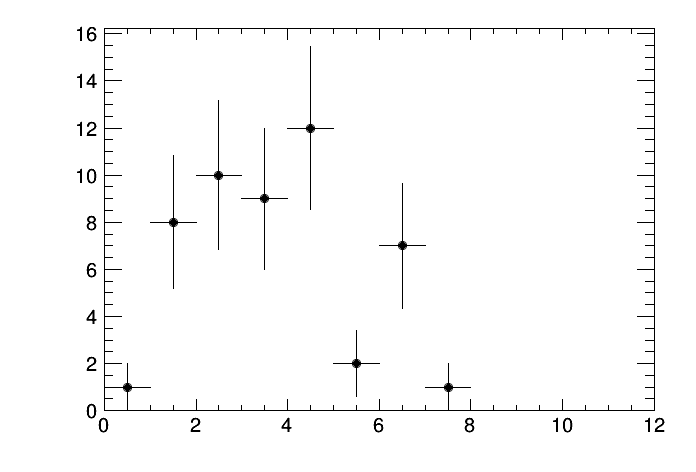

In [3]:
################
# MAIN PROGRAM #
################

# constants
mu0=3.5
ntrials=100

# derived constants
xmin=max(0,int(mu0-5.*math.sqrt(mu0)))
xmax=int(mu0+5.*math.sqrt(mu0))
nbins=xmax-xmin

# lists to be used to plot the graphs
ntoys = []
dntoys = []
crbounds = []

# list of methods
means = {}
dmeans = {}
variances = {}
dvariances = {}
biases = {}
methods = ["LS","MLE","moments","chi2","mchi2","binnedLH"]
for meth in methods:
    means[meth] = []
    dmeans[meth] = []
    variances[meth] = []
    dvariances[meth] = []
    biases[meth] = []

rnd = ROOT.TRandom3()

# loop on the number of toys
for nt in [1,2,3,5,10,20,30,50]:
    ntoys.append(nt)
    dntoys.append(0)
    crbounds.append(1./(nt*(1./mu0)))

    # trials
    estimates = {}
    for meth in methods:
        estimates[meth] = []
        
    for i in range(0,ntrials):
        # toy generation
        toys = []
        htoys = ROOT.TH1I("htoys","",nbins,xmin,xmax)
        for it in range(0,nt):
            toy = rnd.Poisson(mu0)
            toys.append(toy)
            htoys.Fill(toy)

        for meth in methods:
            result=0
            if meth=="MLE":    
                # maximum likelihood estimate
                result = optimize.fmin(lh_poisson,mu0,args=(toys,),disp=False)
            elif meth=="LS":
                # least squares estimate
                result = optimize.fmin(ls_poisson,mu0,args=(toys,),disp=False)
            elif meth=="moments":
                result = numpy.mean(toys)
            elif meth=="chi2":
                result = optimize.fmin(chi2_poisson,mu0,args=(htoys,),disp=False)
            elif meth=="mchi2":
                result = optimize.fmin(mchi2_poisson,mu0,args=(htoys,),disp=False)
            elif meth=="binnedLH":
                result = optimize.fmin(binned_lh_poisson,mu0,args=(htoys,),disp=False)
                
            estimates[meth].append(result)
                
        # delete the histogram... except if it is the last one
        if nt<50 or i<ntrials-1:
            del htoys
        else:
            chist = ROOT.TCanvas("chist","")
            htoys.Draw()
            chist.Draw()

    for meth in methods:
        means[meth].append(numpy.mean(estimates[meth]))
        variances[meth].append(numpy.var(estimates[meth]))
        biases[meth].append(numpy.mean(estimates[meth])-mu0)
        dmeans[meth].append(math.sqrt(variances[meth][-1]/ntrials))
        dvariances[meth].append(math.sqrt(2*variances[meth][-1]**2/(ntrials-1)))

('LS', [3.2140023193359379, 3.7075698242187509, 3.7796009521484377, 3.9589836425781249, 3.9134383544921878, 3.874095825195313, 3.9542036132812508, 3.9419177246093748])
('MLE', [3.4100057373046879, 3.5100035400390635, 3.4533387451171871, 3.5899993896484381, 3.5039981689453121, 3.4220019531249992, 3.4943355712890627, 3.4875996093750001])
('moments', [3.4100000000000001, 3.5099999999999998, 3.4533333333333336, 3.5899999999999999, 3.5039999999999991, 3.4219999999999997, 3.4943333333333326, 3.4876000000000005])
('chi2', [3.4100074462890633, 3.6502239990234373, 3.6270561523437497, 3.7824156494140624, 3.7964746093750001, 3.7232258300781251, 3.7456596679687499, 3.7826250000000012])
('mchi2', [3.4100074462890633, 3.246231201171875, 3.4831878662109377, 3.7076492919921873, 4.0100856933593745, 3.7866667480468745, 3.587147094726562, 3.4565217285156247])
('binnedLH', [3.4100057373046879, 3.5100035400390635, 3.4533387451171871, 3.5735000000000001, 3.5039981689453121, 3.4220019531249992, 3.48227868652

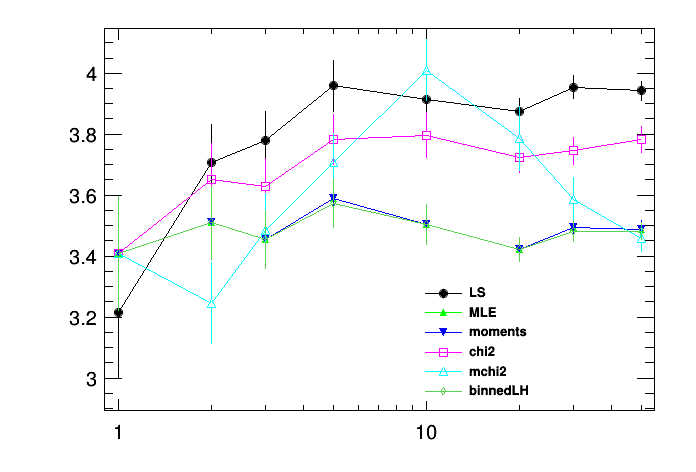

In [4]:
# plot results
nx = len(ntoys)
c1 = ROOT.TCanvas("c1","Mean")
c1.SetLogx()
i=0
gmean = {}
tleg = ROOT.TLegend(0.6,0.15,0.9,0.4)
tleg.SetBorderSize(0)
for meth in methods:
    print(meth,means[meth])
    i=i+1
    if i==5 or i==2:
        i=i+1
    gmean[meth] = ROOT.TGraphErrors(nx,array('d',ntoys),array('d',means[meth]),array('d',dntoys),array('d',dmeans[meth]))
    gmean[meth].SetLineColor(i)
    gmean[meth].SetMarkerColor(i)
    gmean[meth].SetMarkerStyle(19+i)
    if i==1:
        gmean[meth].Draw("ALP")
    else:
        gmean[meth].Draw("LP")
    tleg.AddEntry(gmean[meth],meth,"LP")

tleg.Draw()
c1.Draw()

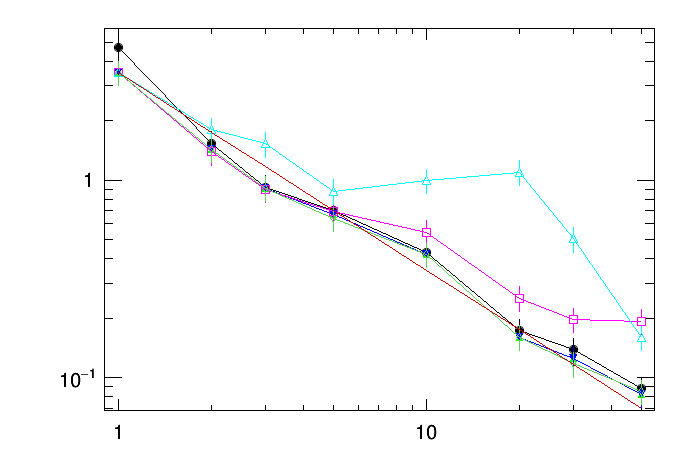

In [5]:
c2 = ROOT.TCanvas("c2","Variance")
c2.SetLogx()
c2.SetLogy()
c1.SetLogx()
i=0
gvar = {}
for meth in methods:
    i=i+1
    if i==5 or i==2:
        i=i+1
    gvar[meth] = ROOT.TGraphErrors(nx,array('d',ntoys),array('d',variances[meth]),array('d',dntoys),array('d',dvariances[meth]))
    gvar[meth].SetLineColor(i)
    gvar[meth].SetMarkerColor(i)
    gvar[meth].SetMarkerStyle(19+i)
    if i==1:
        gvar[meth].Draw("ALP")
    else:
        gvar[meth].Draw("LP")
gcrbound = ROOT.TGraph(nx,array('d',ntoys),array('d',crbounds))
gcrbound.SetLineColor(ROOT.kRed+1)
gcrbound.Draw("L")
c2.Draw()

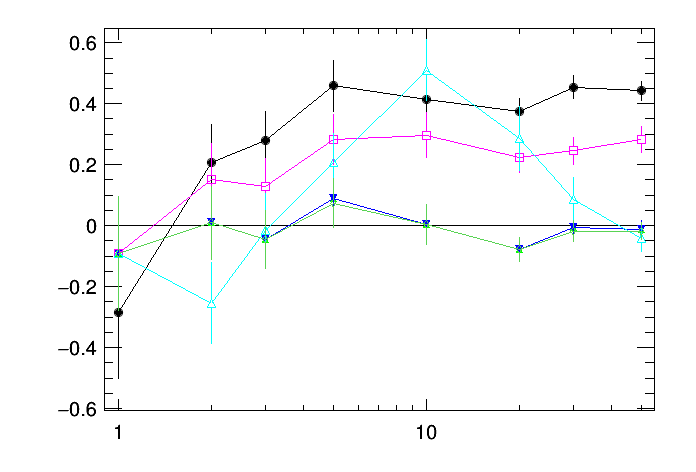

In [6]:
c3 = ROOT.TCanvas("c3","Biases")
c3.SetLogx()
c1.SetLogx()
i=0
gbias = {}
for meth in methods:
    i=i+1
    if i==5 or i==2:
        i=i+1
    gbias[meth] = ROOT.TGraphErrors(nx,array('d',ntoys),array('d',biases[meth]),array('d',dntoys),array('d',dmeans[meth]))
    gbias[meth].SetLineColor(i)
    gbias[meth].SetMarkerColor(i)
    gbias[meth].SetMarkerStyle(19+i)
    if i==1:
        gbias[meth].Draw("ALP")
    else:
        gbias[meth].Draw("LP")
c3.Draw()